In [2]:
import os
import warnings
import torch
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp
from process import utils
from process.utils import normalize_sparse_matrix, sparse_mx_to_torch_sparse_tensor

plt.rcdefaults()
warnings.filterwarnings('ignore')
os.environ['R_HOME'] = 'C:/Program Files/R/R-4.3.1'

In [3]:
sample = '151507'
path = 'D:/st_projects/Path-MGCN/data/DLPFC'
adata = sc.read_visium(path=os.path.join(path, sample), count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()
labels_df = pd.read_table(os.path.join(path, sample, "metadata.tsv"), sep='\t')
labels_df.index = adata.obs.index
adata.obs['ground_truth'] = labels_df["layer_guess_reordered"]
adata = adata[~adata.obs['ground_truth'].isnull()].copy()

In [4]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=3000)
adata = adata[:, adata.var.highly_variable].copy()
adata.layers['counts'] = adata.X.copy()

In [5]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.scale(adata, zero_center=False, max_value=10)

In [6]:
signal_activity = utils.get_signal(adata, prior_file='D:/st_projects/Path-MGCN/data/kegg/gene_sets.gmt', path=os.path.join(path, sample), threads=10)
adata.obsm['signal'] = signal_activity.loc[adata.obs_names].values

spatial_adj, graph_nei = utils.spatial_construct_graph(adata, radius=300) # 560
signal_adj = utils.features_construct_graph(adata.obsm['signal'])

Using existing signal activity file...
The graph contains 36717 undirected edges, 4221 cells.
17.3973 neighbors per cell on average.


In [7]:
features = torch.FloatTensor(adata.X.toarray())
labels = adata.obs['ground_truth'].values

spatial_adj = normalize_sparse_matrix(spatial_adj + sp.eye(adata.shape[0]))
spatial_adj = sparse_mx_to_torch_sparse_tensor(spatial_adj)

signal_adj = normalize_sparse_matrix(signal_adj + sp.eye(adata.shape[0]))
signal_adj = sparse_mx_to_torch_sparse_tensor(signal_adj)

graph_nei_tensor = torch.LongTensor(graph_nei.numpy())

In [9]:
import random
import torch.nn as nn

def model_train(model, optimizer, features, spatial_adj, signal_adj, graph_nei, alpha=1, beta=0.1):
    np.random.seed(42)
    random.seed(42)
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    model.train()
    optimizer.zero_grad()
    embd, rec_adj, pi, disp, mean, att = model(features, spatial_adj, signal_adj)

    # structure loss
    n = graph_nei.size(0)
    diag_mask = torch.eye(n, dtype=torch.bool, device=graph_nei.device)
    mask = ~diag_mask
    num_pos = graph_nei[mask].sum()
    num_all = mask.sum()
    num_neg = num_all - num_pos
    pos_weight = (num_neg / (num_pos + 1e-8)).clamp(max=100.).to(rec_adj.device)
    crit = nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction='none')
    loss_mat = crit(rec_adj, graph_nei.float())
    structure_loss = (loss_mat[mask]).mean()   # 仅对 off-diagonal 求均值

    zinb_loss = SiDMGF.ZINB(pi, theta=disp, ridge_lambda=0).loss(features, mean, mean=True)
    total_loss = alpha * zinb_loss + beta * structure_loss
    total_loss.backward()
    optimizer.step()

    return embd, att, total_loss.item(), pi, disp, mean, att

In [10]:
from tqdm import tqdm
from model import SiDMGF
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

features, spatial_adj, signal_adj = features.to(device), spatial_adj.to(device), signal_adj.to(device)
graph_nei = graph_nei.to(device)

model = SiDMGF.SiDMGF(nfeat=features.shape[1], nhid1=128, nhid2=64, dropout=0.1).to(device)
optimizer = torch.optim.NAdam(model.parameters(), lr=0.001, weight_decay=5e-4)

ari_max = 0
best_emd = None
best_cluster = None
best_mean = None

for epoch in tqdm(range(1, 501), leave=True, desc="Training epochs"):
    model.train()
    optimizer.zero_grad()
    embd, att, loss, pi, disp, mean, att = model_train(model, optimizer, features, spatial_adj, signal_adj, graph_nei, alpha=1, beta=0.1)

    kmeans = KMeans(n_clusters=len(np.unique(labels))).fit(embd.cpu().detach().numpy())
    ari_res = adjusted_rand_score(labels, kmeans.labels_)
    if (epoch % 25 == 0) or (epoch ==1):
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, ARI: {ari_res:.4f}")

    if ari_res > ari_max:
        ari_max = ari_res
        best_emb = embd
        best_clusters = kmeans.labels_
        best_mean = mean

print(f"\n--- Training complete. ARI: {ari_max:.4f} ---")

Training epochs:   0%|          | 2/500 [00:01<04:12,  1.97it/s]

Epoch: 001, Loss: 0.6530, ARI: 0.0472


Training epochs:   5%|▌         | 26/500 [00:05<01:14,  6.40it/s]

Epoch: 025, Loss: 0.5262, ARI: 0.4636


Training epochs:  10%|█         | 51/500 [00:08<01:05,  6.81it/s]

Epoch: 050, Loss: 0.4969, ARI: 0.5529


Training epochs:  15%|█▌        | 76/500 [00:12<01:04,  6.53it/s]

Epoch: 075, Loss: 0.4809, ARI: 0.6313


Training epochs:  20%|██        | 101/500 [00:16<00:58,  6.79it/s]

Epoch: 100, Loss: 0.4703, ARI: 0.6569


Training epochs:  25%|██▌       | 126/500 [00:19<00:53,  6.96it/s]

Epoch: 125, Loss: 0.4635, ARI: 0.6765


Training epochs:  30%|███       | 151/500 [00:23<00:48,  7.23it/s]

Epoch: 150, Loss: 0.4591, ARI: 0.6817


Training epochs:  35%|███▌      | 176/500 [00:26<00:46,  7.01it/s]

Epoch: 175, Loss: 0.4563, ARI: 0.6806


Training epochs:  40%|████      | 201/500 [00:30<00:40,  7.36it/s]

Epoch: 200, Loss: 0.4560, ARI: 0.6479


Training epochs:  45%|████▌     | 226/500 [00:33<00:39,  6.87it/s]

Epoch: 225, Loss: 0.4536, ARI: 0.6552


Training epochs:  50%|█████     | 251/500 [00:37<00:34,  7.13it/s]

Epoch: 250, Loss: 0.4523, ARI: 0.6590


Training epochs:  55%|█████▌    | 276/500 [00:40<00:33,  6.73it/s]

Epoch: 275, Loss: 0.4511, ARI: 0.6466


Training epochs:  60%|██████    | 301/500 [00:44<00:29,  6.73it/s]

Epoch: 300, Loss: 0.4503, ARI: 0.6423


Training epochs:  65%|██████▌   | 326/500 [00:47<00:24,  7.00it/s]

Epoch: 325, Loss: 0.4494, ARI: 0.6223


Training epochs:  70%|███████   | 351/500 [00:51<00:19,  7.47it/s]

Epoch: 350, Loss: 0.4491, ARI: 0.5703


Training epochs:  75%|███████▌  | 376/500 [00:54<00:17,  7.10it/s]

Epoch: 375, Loss: 0.4480, ARI: 0.5800


Training epochs:  80%|████████  | 401/500 [00:58<00:14,  7.03it/s]

Epoch: 400, Loss: 0.4495, ARI: 0.5792


Training epochs:  85%|████████▌ | 426/500 [01:01<00:10,  7.33it/s]

Epoch: 425, Loss: 0.4465, ARI: 0.5585


Training epochs:  90%|█████████ | 451/500 [01:05<00:06,  7.31it/s]

Epoch: 450, Loss: 0.4645, ARI: 0.5336


Training epochs:  95%|█████████▌| 476/500 [01:08<00:03,  6.75it/s]

Epoch: 475, Loss: 0.4463, ARI: 0.5674


Training epochs: 100%|██████████| 500/500 [01:12<00:00,  6.92it/s]

Epoch: 500, Loss: 0.4451, ARI: 0.4920

--- Training complete. ARI: 0.6870 ---


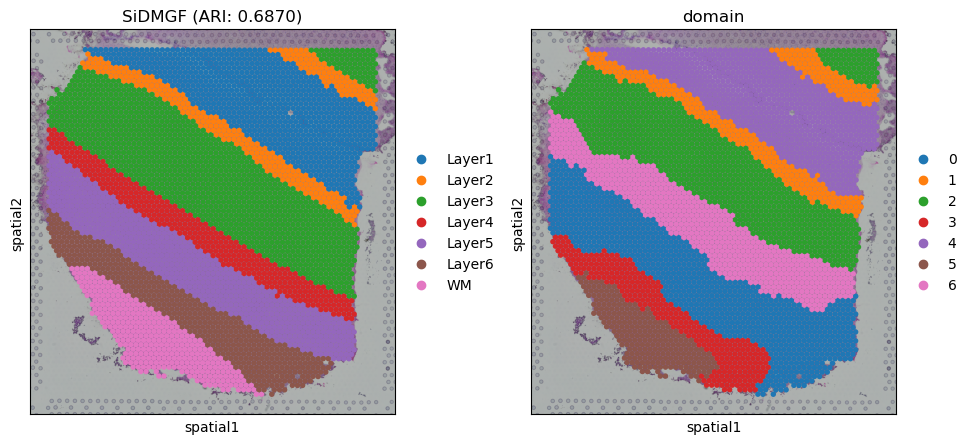

In [11]:
save_dir = f'D:/st_projects/SiDMGF/result/DLPFC/{sample}/'
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)

adata.obs['domain'] = pd.Categorical(best_clusters)

plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.spatial(
    adata,
    img_key="hires",
    color=['ground_truth', 'domain'],
    title=f'SiDMGF (ARI: {ari_max:.4f})',
    show=True,
    size=1.5,
)

In [12]:
import ot

def refine_label(adata, radius=50, key='label'):
    n_neigh = radius
    new_type = []
    old_type = adata.obs[key].values

    #calculate distance
    position = adata.obsm['spatial']
    distance = ot.dist(position, position, metric='euclidean')

    n_cell = distance.shape[0]

    for i in range(n_cell):
        vec  = distance[i, :]
        index = vec.argsort()
        neigh_type = []
        for j in range(1, n_neigh+1):
            neigh_type.append(old_type[index[j]])
        max_type = max(neigh_type, key=neigh_type.count)
        new_type.append(max_type)

    new_type = [str(i) for i in list(new_type)]
    #adata.obs['label_refined'] = np.array(new_type)

    return new_type

In [13]:
from process.utils import BestMap

sc.set_figure_params(scanpy=True, dpi=80, dpi_save=600, frameon=True, vector_friendly=False, fontsize=12, figsize=(5, 4), color_map=None, format='pdf', facecolor=None, transparent=True, ipython_format='png2x')

new_type = refine_label(adata, 20, key='domain')
adata.obs["refined_pred"] = new_type
adata.obs["refined_pred"] = adata.obs["refined_pred"].astype('category')

adata.obs['pred'] = BestMap(pd.Categorical(adata.obs['ground_truth']).codes, pd.Categorical(adata.obs['domain']).codes)
adata.obs['pred'] = adata.obs['pred'].astype('category')

adata.obs['refined_pred'] = BestMap(pd.Categorical(adata.obs['ground_truth']).codes, pd.Categorical(adata.obs['refined_pred']).codes)
adata.obs['refined_pred'] = adata.obs['refined_pred'].astype('category')

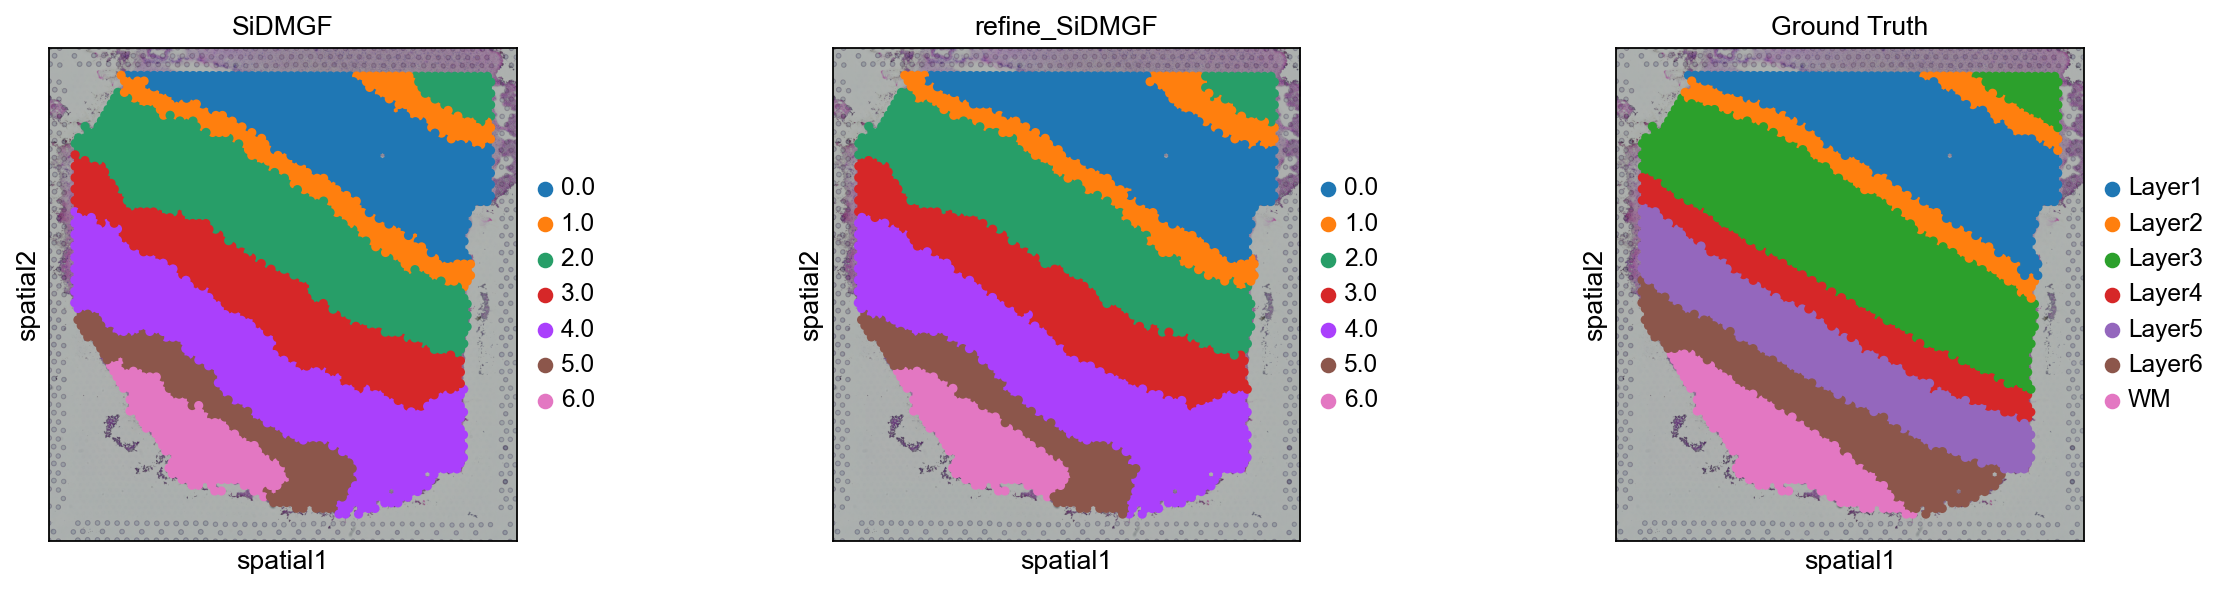

In [15]:
sc.pl.spatial(adata, color=['pred', 'refined_pred', 'ground_truth'], title=['SiDMGF', 'refine_SiDMGF', 'Ground Truth'], size=2)

In [16]:
ari_refine = adjusted_rand_score(adata.obs['ground_truth'], adata.obs['refined_pred'])
ari_refine

0.6872361060859709

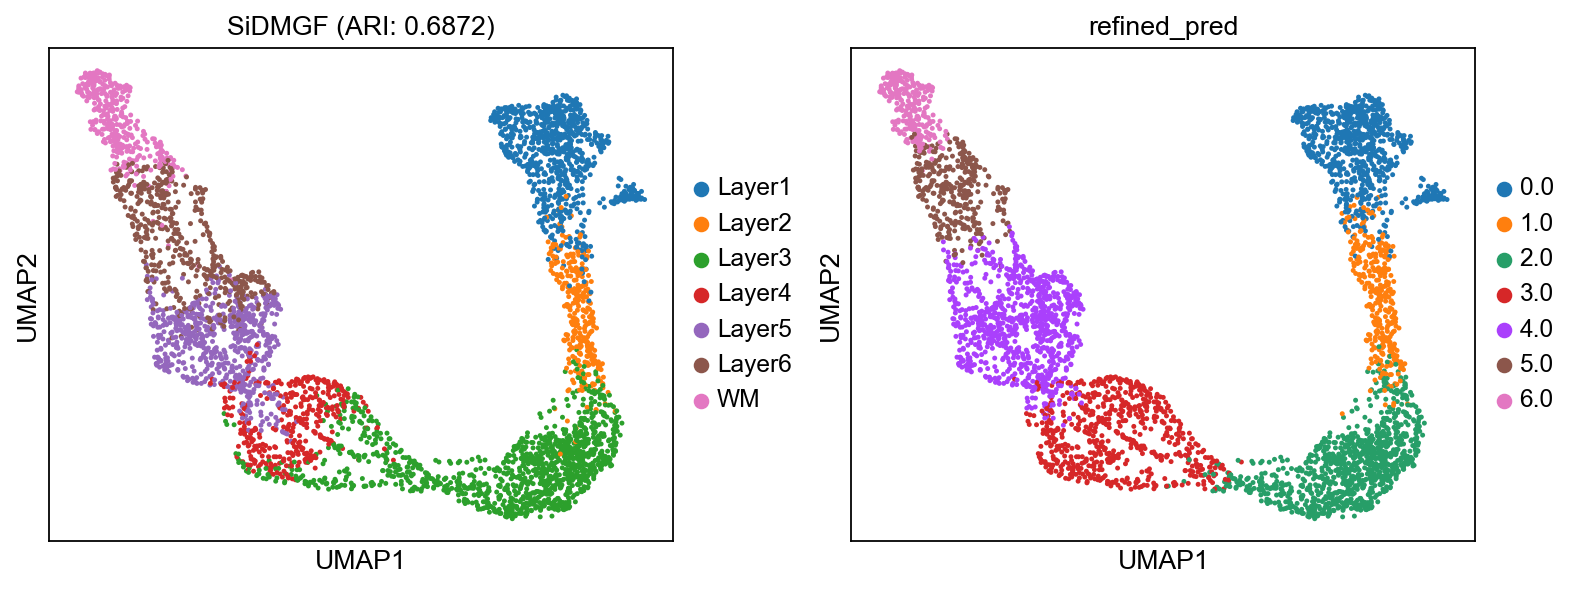

In [17]:
adata.obsm['embd'] = best_emb.cpu().detach().numpy()
sc.pp.neighbors(adata, use_rep='embd')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['ground_truth', 'refined_pred'], title=f'SiDMGF (ARI: {ari_refine:.4f})', size=20)

In [18]:
from process.utils import mclust_R

adata = mclust_R(adata, used_obsm='embd', num_cluster=7)
adata

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 4221 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth', 'domain', 'refined_pred', 'pred', 'mclust'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'ground_truth_colors', 'domain_colors', 'pred_colors', 'refined_pred_colors', 'neighbors', 'umap'
    obsm: 'spatial', 'signal', 'embd', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

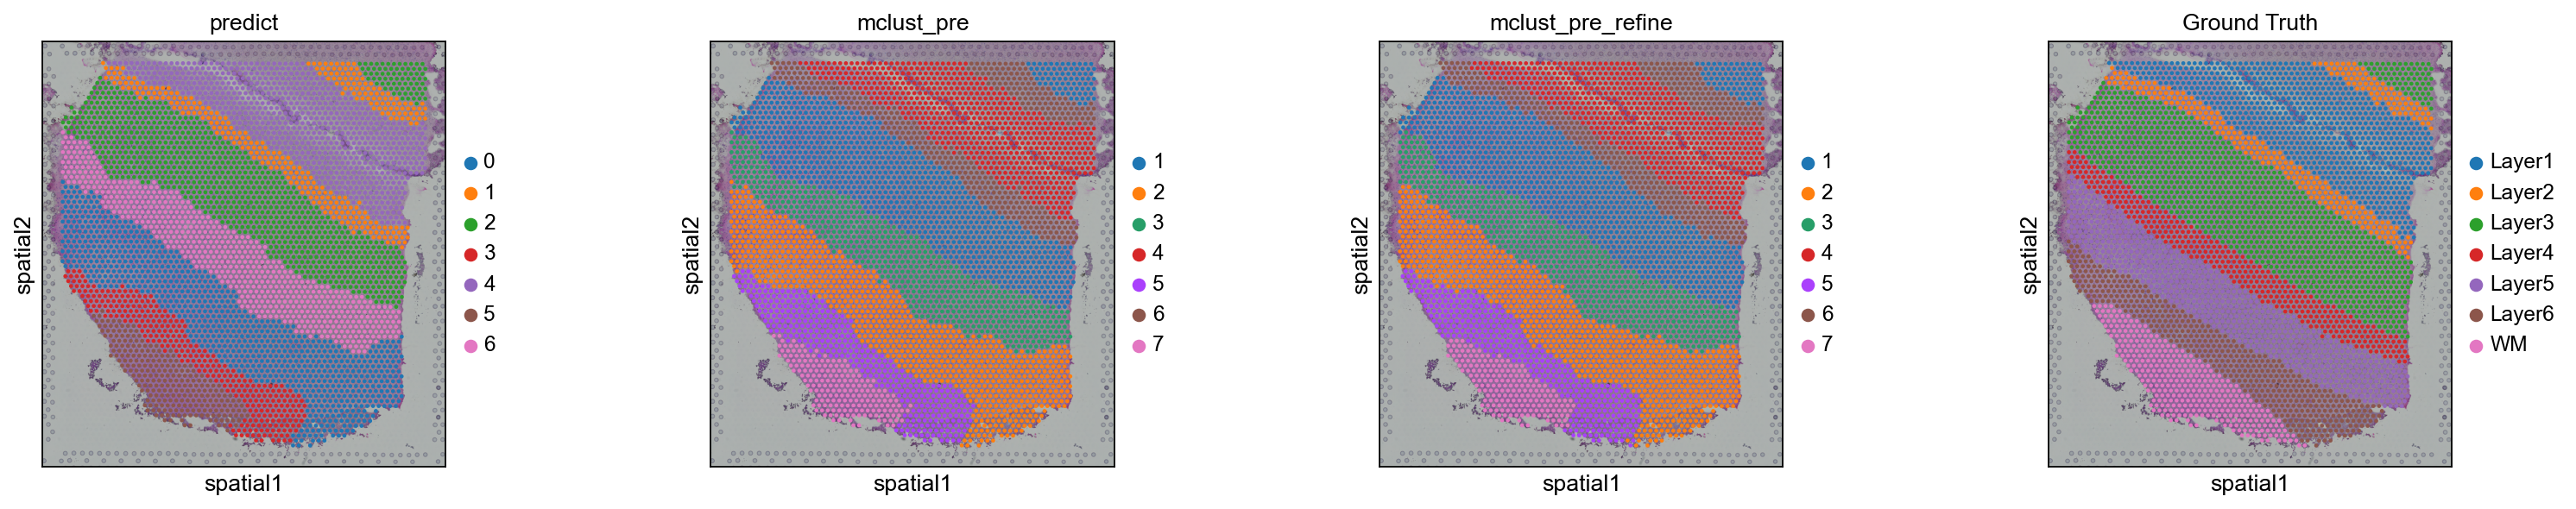

In [19]:
new_type = refine_label(adata, 10, key='mclust')
adata.obs["refined_pred"] = new_type
adata.obs["refined_pred"] = adata.obs["refined_pred"].astype('category')
sc.pl.spatial(adata, color=['domain', 'mclust', 'refined_pred', 'ground_truth'], title=['predict', 'mclust_pre', 'mclust_pre_refine', 'Ground Truth'])

In [20]:
adata.obs['mclust_pred'] = BestMap(pd.Categorical(adata.obs['ground_truth']).codes, pd.Categorical(adata.obs['mclust']).codes)
adata.obs['mclust_pred'] = adata.obs['mclust_pred'].astype('category')

adata.obs['mclust_pre_refine'] = BestMap(pd.Categorical(adata.obs['ground_truth']).codes, pd.Categorical(adata.obs['refined_pred']).codes)
adata.obs['mclust_pre_refine'] = adata.obs['mclust_pre_refine'].astype('category')

In [21]:
adjusted_rand_score(adata.obs['ground_truth'], adata.obs['mclust_pre_refine'])

0.6380036923626402

In [22]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=600, frameon=True, vector_friendly=False, fontsize=12, figsize=(5, 4), color_map=None, format='pdf', facecolor=None, transparent=True, ipython_format='png2x')

sc.pl.spatial(adata, color=['mclust', 'mclust_pre_refine', 'ground_truth'], title=['mclust_pre', 'mclust_pre_refine', 'Ground Truth'], size=2)

In [23]:
rec_exp = best_mean.cpu().detach().numpy()
adata.layers['SiDMGF'] = sp.csr_matrix(rec_exp)

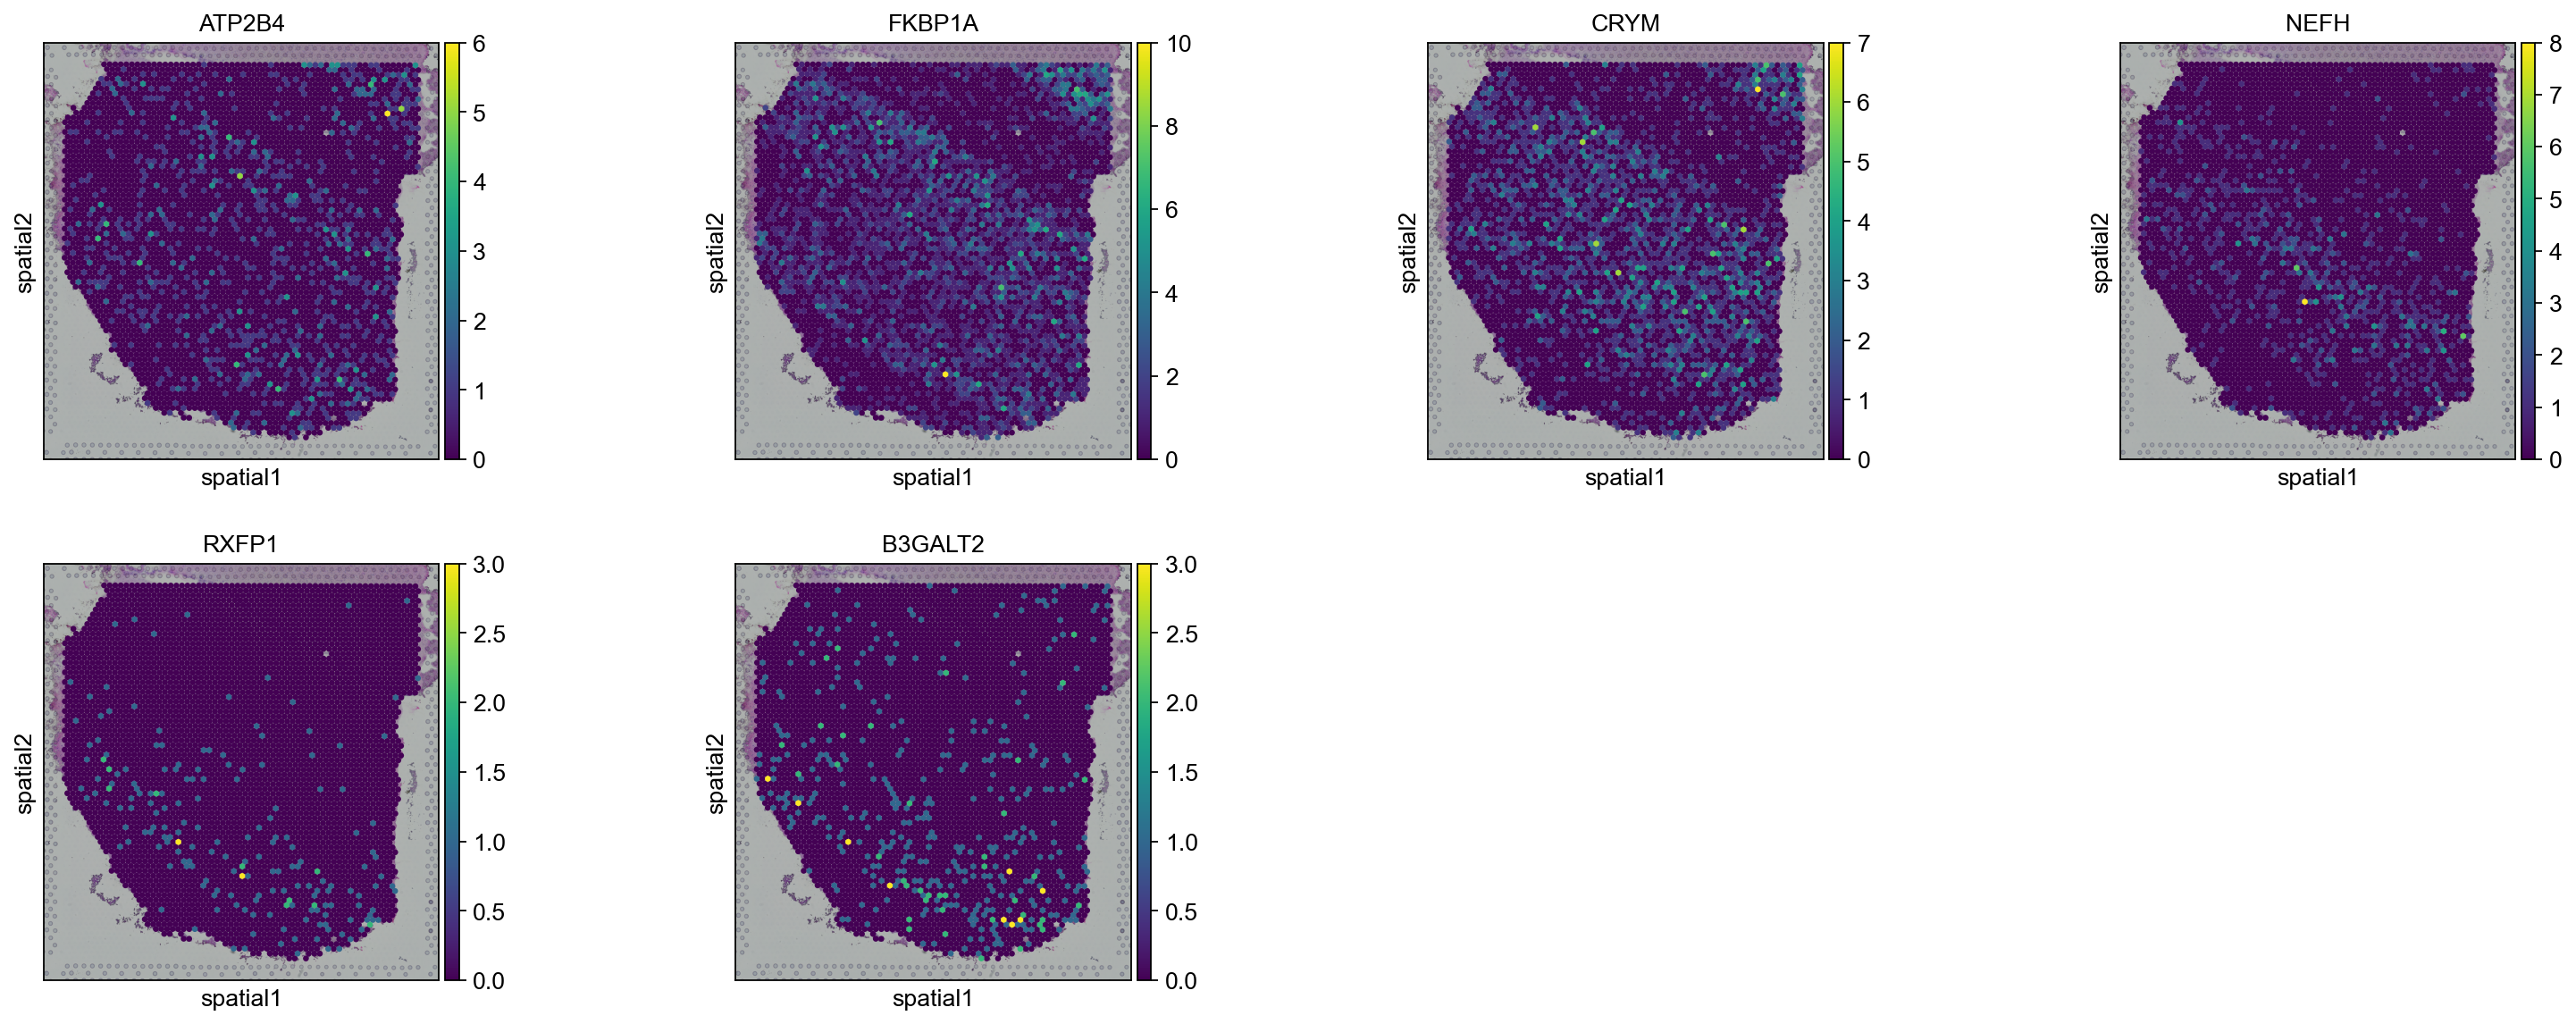

In [31]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=600, frameon=True, vector_friendly=True, fontsize=12, figsize=(5, 4), color_map=None, format='pdf', facecolor=None, transparent=True, ipython_format='png2x')

markers = ['ATP2B4', 'FKBP1A', 'CRYM', 'NEFH', 'RXFP1', 'B3GALT2']
marker_mucst = ['C1QL2', 'NTNG1', 'GABRA5', 'ACTA2']
sc.pl.spatial(adata, color=markers, layer='counts', size=1.5, save='exp_raw', groups=['2'])
sc.pl.spatial(adata, color=markers, layer='SiDMGF', size=1.5, save='exp_SiDMGF')

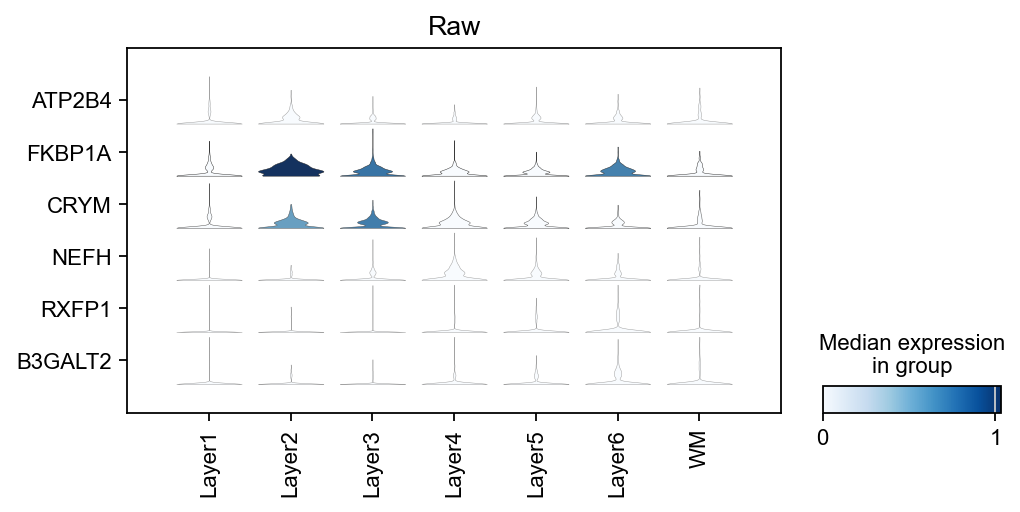

In [33]:
sc.pl.stacked_violin(adata, markers, title='Raw', groupby='ground_truth', swap_axes=True, figsize=[7, 3], show=True, save='stacked_violin_Raw')
# plt.savefig(savepath + 'stacked_violin_Raw.jpg', bbox_inches='tight', dpi=600)
# plt.show()

sc.pl.stacked_violin(adata, markers, layer='SiDMGF', title='SiDMGF', groupby='ground_truth', swap_axes=True, figsize=[7, 3], show=True, save='stacked_violin_SiDMGF')
# plt.savefig(savepath + 'stacked_violin_Spatial_MGCN.jpg', bbox_inches='tight', dpi=600)
# plt.show()